In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#Generator 
class Generator(nn.Module):
    def __init__(self, num_classes=10, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, nz)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz*2, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        embedding = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        z = torch.cat([z, embedding], dim=1)
        return self.model(z)


In [3]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, ndf=64, nc=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2),
        )

        self.validity_layer = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.labels = nn.Sequential(
            nn.Conv2d(ndf * 8, num_classes, 4, 1, 0, bias=False),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        validity = self.validity_layer(x).view(-1, 1)
        label = self.labels(x).view(-1, 10)
        return validity, label


In [4]:
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.nn.functional as F

# Data loader
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified


In [5]:
# Initialize the models
G = Generator().to(device)
D = Discriminator().to(device)

# Initialize the optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


In [6]:
output_dir = Path("Images/acganimages")
output_dir.mkdir(parents=True, exist_ok=True)
real_images_dir = Path(output_dir / "real")
real_images_dir.mkdir(parents=True, exist_ok=True)
fake_images_dir = Path(output_dir / "fake")
fake_images_dir.mkdir(parents=True, exist_ok=True)


In [7]:

best_images = []
best_scores = []

# Set the number of training epochs
epochs = 50

# Training loop
for epoch in range(epochs):
    for i, (real_data, real_labels) in enumerate(train_loader):
        batch_size = real_data.size(0)
        real_data, real_labels = real_data.to(device), real_labels.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real data
        real_validity, real_label = D(real_data)
        real_validity_loss = F.binary_cross_entropy(real_validity, torch.ones_like(real_validity))
        real_label_loss = F.nll_loss(real_label, real_labels)
        real_loss = real_validity_loss + real_label_loss

        # Fake data
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        sample_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
        fake_data = G(noise, sample_labels)
        fake_validity, fake_label = D(fake_data.detach())
        fake_validity_loss = F.binary_cross_entropy(fake_validity, torch.zeros_like(fake_validity))
        fake_label_loss = F.nll_loss(fake_label, sample_labels)
        fake_loss = fake_validity_loss + fake_label_loss

        # Update Discriminator
        dis_loss = real_loss + fake_loss
        dis_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake data
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        sample_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
        fake_data = G(noise, sample_labels)
        fake_validity, fake_label = D(fake_data)
        fake_validity_loss = F.binary_cross_entropy(fake_validity, torch.ones_like(fake_validity))
        fake_label_loss = F.nll_loss(fake_label, sample_labels)

        # Update Generator
        gen_loss = fake_validity_loss + fake_label_loss
        gen_loss.backward()
        optimizer_G.step()
        
    with torch.no_grad():
        #fixed_noise = torch.randn(100, 100, 1, 1, device=device)
        #labels = torch.randint(0, 10, (100,), device=device, dtype=torch.long)
        generated_images = G(noise,sample_labels).detach().cpu()
        
        fake_validity, _ = D(generated_images.to(device))
        img_scores = fake_validity.detach().cpu().numpy()

        
        # Update the best images list
        for img, score in zip(generated_images, img_scores):
            if len(best_images) < 10:
                best_images.append(img)
                best_scores.append(score)
            else:
                min_index = best_scores.index(min(best_scores))
                if score > best_scores[min_index]:
                    best_images[min_index] = img
                    best_scores[min_index] = score 
    
   # if epoch == epochs-1:
        
        #for idx, img in enumerate(real_data.cpu()):
            #vutils.save_image(img, real_images_dir/f"real_image{epoch}_{idx}.png", normalize=True)
       # for idx, img in enumerate(generated_images.cpu()):
       #     vutils.save_image(img, fake_images_dir/f"fake_image{epoch}_{idx}.png", normalize=True)
            
    print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")
    

        #if i % 300 == 0:
           # print(f"Epoch [{epoch+1}/{epochs}] | Batch [{i+1}/{len(train_loader)}] | D_loss: {dis_loss.item():.4f} | G_loss: {gen_loss.item():.4f}")

Epoch [1/50] | D_loss: 2.3902 | G_loss: 2.9755
Epoch [2/50] | D_loss: 2.0401 | G_loss: 5.6171
Epoch [3/50] | D_loss: 1.6876 | G_loss: 2.3725
Epoch [4/50] | D_loss: 1.4982 | G_loss: 3.5373
Epoch [5/50] | D_loss: 0.9634 | G_loss: 4.4895
Epoch [6/50] | D_loss: 1.5044 | G_loss: 2.3628
Epoch [7/50] | D_loss: 1.3683 | G_loss: 7.9031
Epoch [8/50] | D_loss: 0.6338 | G_loss: 3.5586
Epoch [9/50] | D_loss: 1.4440 | G_loss: 7.3910
Epoch [10/50] | D_loss: 1.6524 | G_loss: 3.3640
Epoch [11/50] | D_loss: 2.4120 | G_loss: 3.4725
Epoch [12/50] | D_loss: 0.4819 | G_loss: 10.8343
Epoch [13/50] | D_loss: 1.4160 | G_loss: 1.5316
Epoch [14/50] | D_loss: 0.6823 | G_loss: 3.0288
Epoch [15/50] | D_loss: 2.5769 | G_loss: 4.9562
Epoch [16/50] | D_loss: 0.3999 | G_loss: 6.4809
Epoch [17/50] | D_loss: 0.5301 | G_loss: 7.9789
Epoch [18/50] | D_loss: 0.8485 | G_loss: 10.7262
Epoch [19/50] | D_loss: 0.3070 | G_loss: 5.1198
Epoch [20/50] | D_loss: 0.7492 | G_loss: 6.7338
Epoch [21/50] | D_loss: 1.2394 | G_loss: 7.4176

In [8]:
num_images = 0

for images, _ in train_loader:
    if num_images >= 1000:
        break

    for idx, img in enumerate(images):
        if num_images >= 1000:
            break
        vutils.save_image(img, real_images_dir / f"real_image_{num_images}.png", normalize=True)
        num_images += 1

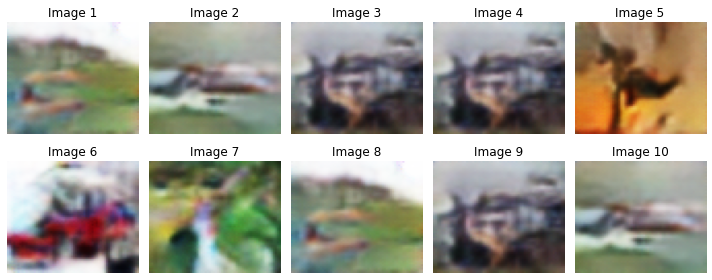

In [9]:
# Plot the 10 best generated images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, img in enumerate(best_images):
    ax = axes[i // 5, i % 5]
    img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
    ax.imshow(img_np, aspect="auto")
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
Noise = torch.randn(1000, 100, 1, 1, device=device)
Labels = torch.randint(0, 10, (1000,), device=device, dtype=torch.long)
Generated_images = G(Noise,Labels).detach().cpu()
for idx, img in enumerate(Generated_images.cpu()):
    vutils.save_image(img, fake_images_dir/f"fake_image_{idx}.png", normalize=True)

In [ ]:
import os
from PIL import Image
from torchmetrics.image.fid import FrechetInceptionDistance

real_image_dir = "/home/jingjiw/Images/acganimages/real"
fake_image_dir = "/home/jingjiw/Images/acganimages/fake"
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

def read_and_preprocess_image(img_path):
    img = Image.open(img_path)
    preprocessed_img = preprocess(img)
    return (preprocessed_img * 255).byte()


real_image_files = [f'real_image_{i}.png' for i in range(1000)]
fake_image_files = [f'fake_image_{i}.png' for i in range(1000)]

real_images = torch.stack([read_and_preprocess_image(os.path.join(real_image_dir, file)) for file in real_image_files])
fake_images = torch.stack([read_and_preprocess_image(os.path.join(fake_image_dir, file)) for file in fake_image_files])

fid = FrechetInceptionDistance()

fid.update(real_images, real=True)
fid.update(fake_images, real=False)

fid_score = fid.compute()
print("FID score:", fid_score)